In [1]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

if cuda:
    torch.cuda.manual_seed(SEED)

In [2]:
NetTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))                               
])



In [3]:
class_names = range(10)

In [4]:
# Two CNN + two FC Layers NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # use nn.Sequential() for each layer1 and layer2, with nn.Conv2d + nn.ReLU + nn.MaxPool2d
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels =1, out_channels =3, kernel_size=(2,2)), # output dimension = (28-2+1)*27*3= 2187
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=1) # output dimension = (27-2+1)*26*3 = 
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels =9, kernel_size=(2,2)), # output dimension = (26-2+1)*25*9
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=1) #output dimension = (25-2+1)*24*9 = 5184
        )
        # use nn.Linear with 1000 neurons
        self.fc1 = nn.Linear(5184, 1000)
        # use nn.Linear to output a one hot vector to encode the output
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # use reshape() to match the input of the FC layer1
        out = out.reshape(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        # use F.log_softmax() to normalize the output
        sm = nn.functional.log_softmax(out, _stacklevel=3)
        return sm

# Another model inspired from LeNet
class Model_Type_LeNet(nn.Module):
    def __init__(self):
        super(Model_Type_LeNet, self).__init__()
        # use nn.Sequential() for each layer1 and layer2, with nn.Conv2d + nn.ReLU + nn.MaxPool2d
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels =1, out_channels =6, kernel_size=(5,5)), # output dimension = (28-5+1)*24*6= 2187
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2) # output dimension = ((24-2)%2+1)*12*6 = 
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels =6, out_channels =16, kernel_size=(5,5)), # output dimension = (12-5+1)*8*16
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2) #output dimension = ((8-2)%2+1)*4*16 = 256
        )
        # use nn.Linear with 1000 neurons
        self.fc1 = nn.Linear(256, 1000)
        # use nn.Linear to output a one hot vector to encode the output
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # print(out.size())
        # use reshape() to match the input of the FC layer1
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        # use F.log_softmax() to normalize the output
        sm = nn.functional.log_softmax(out, _stacklevel=3)
        return sm
    
    
model_lenet = Model_Type_LeNet() # model type LeNet is not good for this applciation. Maybe it's because of the dimensions of the input picture or the MaxPool2d instead of the MeanPool2D

model_lenet.to(device)
# use an optim.Adam() optimizer
optimizer = optim.Adam(model_lenet.parameters(),  lr=0.001)



In [5]:
BATCH_SIZE=256

train_loader = dataloader.DataLoader(
    MNIST('./data', train=True, download=True, transform=NetTransform), 
    batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

test_loader = dataloader.DataLoader(
    MNIST('./data', train=False, download=True, transform=NetTransform), 
    batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)



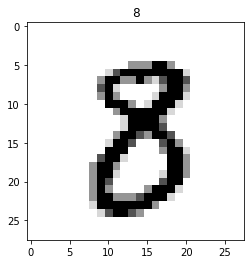

In [6]:
import torchvision
from functions.plot_picture import matplotlib_imshow
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# creat grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid, class_names[labels[0]])
# print()

In [7]:
from functions.training import train_model, evaluate_model

losses = []
accuracies = []
EPOCHS = 10
batch_size = 256
nb_batch = int(np.ceil(len(train_loader.dataset)/batch_size))

for epoch in range(EPOCHS):
  losses.extend(train_model(train_loader, device, model_lenet, optimizer, epoch, EPOCHS, batch_size)[-nb_batch:])
  accuracies.append(evaluate_model(model_lenet, device, test_loader, losses[-1], EPOCHS, epoch, batch_size, len(train_loader.dataset)))

C:\Users\User\Anaconda3\envs\Python\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 Train Epoch: 1/10 [60000/60000 (100%)]	Loss: 0.057342	 Test Accuracy: 97.6100%
 Train Epoch: 2/10 [60000/60000 (100%)]	Loss: 0.039022	 Test Accuracy: 98.3100%
 Train Epoch: 3/10 [60000/60000 (100%)]	Loss: 0.092489	 Test Accuracy: 98.6700%
 Train Epoch: 4/10 [60000/60000 (100%)]	Loss: 0.049580	 Test Accuracy: 98.3800%
 Train Epoch: 5/10 [60000/60000 (100%)]	Loss: 0.047314	 Test Accuracy: 98.6300%
 Train Epoch: 6/10 [60000/60000 (100%)]	Loss: 0.019833	 Test Accuracy: 98.9700%
 Train Epoch: 7/10 [60000/60000 (100%)]	Loss: 0.090086	 Test Accuracy: 98.8500%
 Train Epoch: 8/10 [60000/60000 (100%)]	Loss: 0.029846	 Test Accuracy: 99.0300%
 Train Epoch: 9/10 [60000/60000 (100%)]	Loss: 0.001387	 Test Accuracy: 98.7000%
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.006873	 Test Accuracy: 98.6700%


(0.0, 1.0)

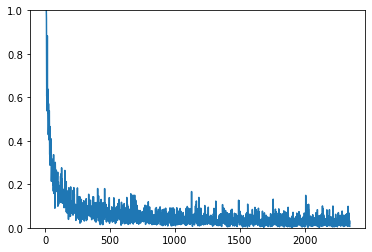

In [8]:
plt.plot(losses)
plt.ylim(0,1)

<generator object Module.modules at 0x000002DC37653C48>


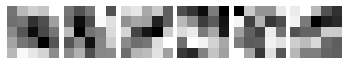

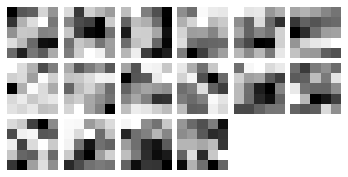

In [9]:
from functions.plot_model import *

model = model_lenet



print(model.modules())
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        # find the weight tensor for each module...
        plot_kernels(m.weight.data.cpu().numpy()) # .data.cpu().numpy() -> transfer data from gpu to cpu to use kernel


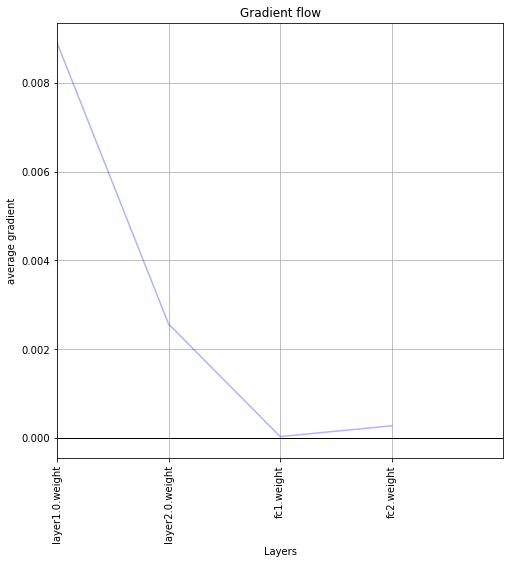

In [10]:
layers = []
for n, p in model.named_parameters():
    if(p.requires_grad) and ("bias" not in n):
        layers.append(n)
fig = plt.figure(figsize=(8,8))
ax = fig.subplots()
plt.xlabel("mini batch")
plt.ylabel("Average Gradient")
plt.title("Gradient Flow")
plt.grid(True)

plot_grad_flow(model.named_parameters())